In [17]:
import PIL.Image
import torch
import kornia
import numpy as np

In [149]:
image = PIL.Image.open('/root/autodl-tmp/fsc147-controlnet/image/0.png')
density = PIL.Image.open('/root/autodl-tmp/fsc147-controlnet/density/0.png')

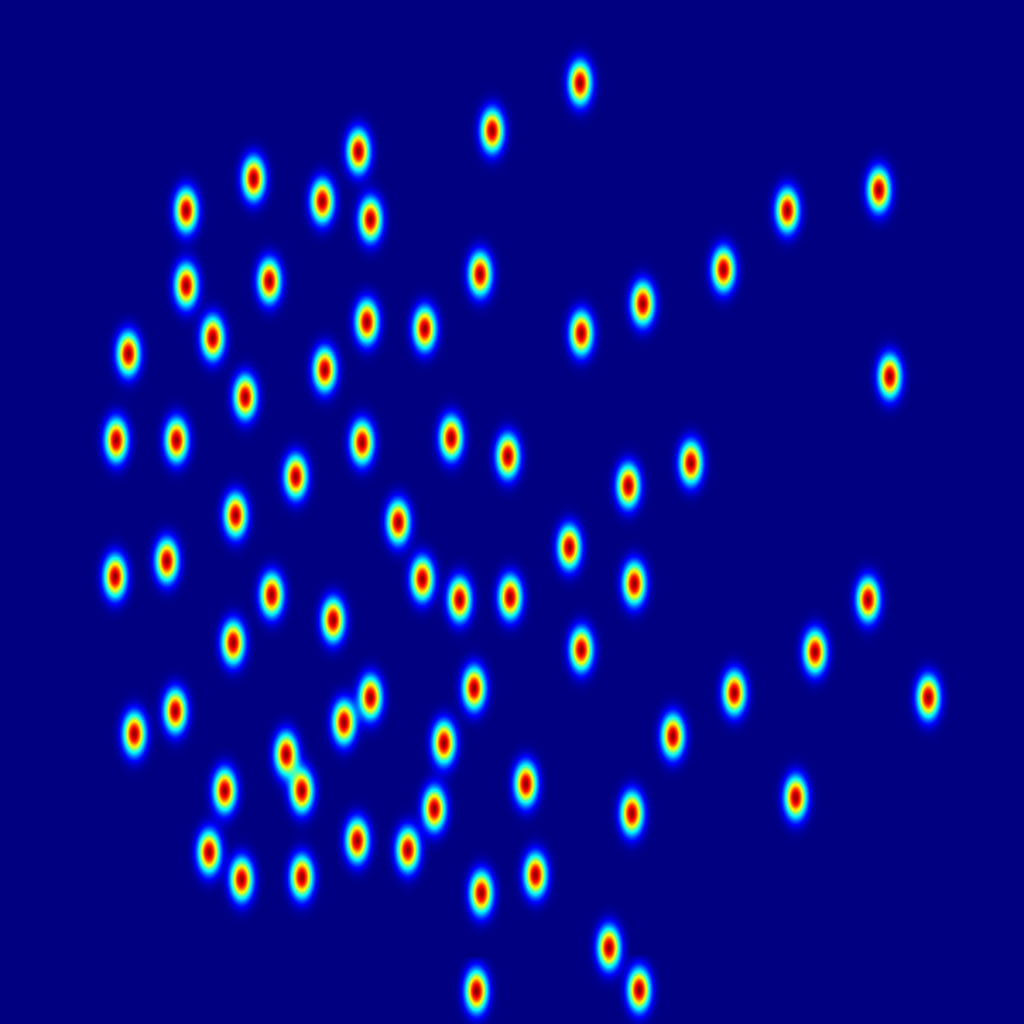

In [150]:
density

In [151]:
image.size,density.size

((1024, 1024), (1024, 1024))

In [4]:
from clip_count.run import Model
model =  Model.load_from_checkpoint("/root/code/count_token_optimization/clip_count/clipcount_pretrained.ckpt", strict=False).cuda()
model.eval()

Lightning automatically upgraded your loaded checkpoint from v1.8.0 to v2.5.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../count_token_optimization/clip_count/clipcount_pretrained.ckpt`


Model(
  (model): CLIPCount(
    (clip): CLIP(
      (visual): VisionTransformer(
        (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
        (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (transformer): Transformer(
          (resblocks): Sequential(
            (0): ResidualAttentionBlock(
              (attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
              )
              (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (mlp): Sequential(
                (c_fc): Linear(in_features=768, out_features=3072, bias=True)
                (gelu): QuickGELU()
                (c_proj): Linear(in_features=3072, out_features=768, bias=True)
              )
              (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            )
            (1): ResidualAttentionBlock(
              (attn): MultiheadAttent

In [6]:
from diffusers.image_processor import VaeImageProcessor
image_processor = VaeImageProcessor(vae_scale_factor=8)
img_tensor = image_processor.preprocess(image).to('cuda')

In [8]:
def transform_img_tensor(image):
    """
    Transforms an image based on the specified classifier input configurations.
    """
    # image = kornia.geometry.transform.resize(image, 224, interpolation="bicubic")
    image = kornia.geometry.transform.resize(image, 224)
    image = kornia.geometry.transform.center_crop(image, (224, 224))
    # image = T.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)(image)
    return image

In [91]:
img_tensor = transform_img_tensor(img_tensor)
with torch.cuda.amp.autocast():
    orig_output = model(img_tensor, "A photo of 71 nuts")



/tmp/ipykernel_40217/4040540783.py:2: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


In [160]:
density_IMG =  density.convert("L")
density_IMG_array = np.array(density_IMG).astype(np.float32)

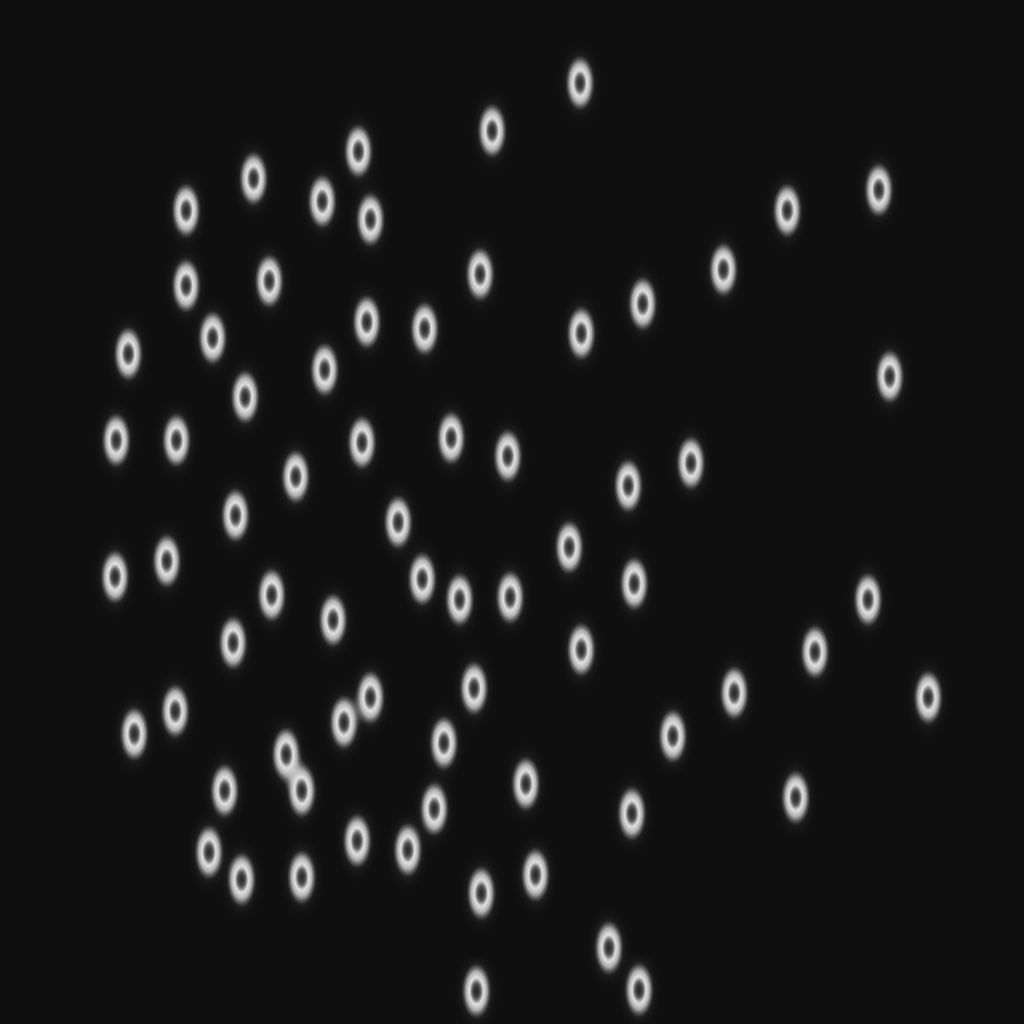

In [161]:
density_IMG

In [162]:
density_IMG_arra = (density_IMG_array-density_IMG_array.min())/density_IMG_array.max()

In [163]:
density_IMG_arra
density_IMG_arra.max(), density_IMG_arra.min(), np.sum(density_IMG_arra),np.sum(density_IMG_arra)/71

(0.9380531, 0.0, 51823.113, 729.9030039612676)

In [164]:
density_IMG_arra[density_IMG_arra>=0.5]=1
density_IMG_arra[density_IMG_arra<0.5]=0

In [165]:
density_IMG_arra.max(), density_IMG_arra.min(), np.sum(density_IMG_arra),np.sum(density_IMG_arra)/71

(1.0, 0.0, 44655.0, 628.943661971831)

In [64]:
orig_output.max(), orig_output.min(), orig_output.mean(), orig_output.std(),orig_output.sum()

(tensor(0.9507, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>),
 tensor(0.0002, device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>),
 tensor(0.0322, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>),
 tensor(0.0552, device='cuda:0', dtype=torch.float16, grad_fn=<StdBackward0>),
 tensor(4752., device='cuda:0', dtype=torch.float16, grad_fn=<SumBackward0>))

In [59]:
orig_output.shape

torch.Size([1, 384, 384])

In [60]:
output = output.squeeze(1)

pred_cnt = torch.sum(output[0]/60).item()

In [61]:
pred_cnt

79.1875